# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Aug25-1429'

In [4]:
concord_methods = ['concord_hcl', 'concord_knn']
other_methods = [
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi",  'contrastive'
]
run_methods =  other_methods + concord_methods
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]

In [5]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
batch_type = 'batch_specific_features'
distribution = 'normal'
leiden_key = 'leiden_no_noise'

## Simulation

In [16]:
from concord.simulation import (
    Simulation,
    SimConfig,
    TrajectoryConfig,   # ← because state_type == 'trajectory'
    BatchConfig,
)

# ── 1. global simulation settings ──────────────────────────────────
sim_cfg = SimConfig(
    n_cells = 1000,
    n_genes = 1000,
    seed    =    42,
    non_neg =  True,
    to_int  =  True,
)

# ── 2. trajectory (state) settings ─────────────────────────────────
traj_cfg = TrajectoryConfig(
    # generic “state” parameters
    distribution   = "normal",   # ← state_distribution
    level          = 10,         # ← state_level
    min_level      = 0,          # ← state_min_level
    dispersion     = 6.0,        # ← state_dispersion

    # trajectory-specific knobs (copied 1-to-1)
    program_num            = 5,              # trajectory_program_num
    program_structure      = "linear_bidirectional",
    program_on_time_fraction = 0.2,
    cell_block_size_ratio  = 0.6,
    loop_to                = None,
)

# ── 3. batch settings ──────────────────────────────────────────────
batch_cfg = BatchConfig(
    n_batches    = 2,
    effect_type  = "batch_specific_features",    # batch_type
    distribution = "normal",                     # batch_distribution
    level        = [10, 10],                     # batch_level
    dispersion   = [6.0, 6.0],                   # batch_dispersion
    feature_frac = 0.1,                          # matches the old default
    # cell_proportion defaults to [0.5, 0.5] because n_batches = 2
)

# ── 4. run the simulation ──────────────────────────────────────────
sim   = Simulation(sim_cfg, traj_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()

# keep the “counts” layer your downstream code expects
adata.layers["counts"] = adata.X.copy()
print(adata.shape)

(1000, 1200)


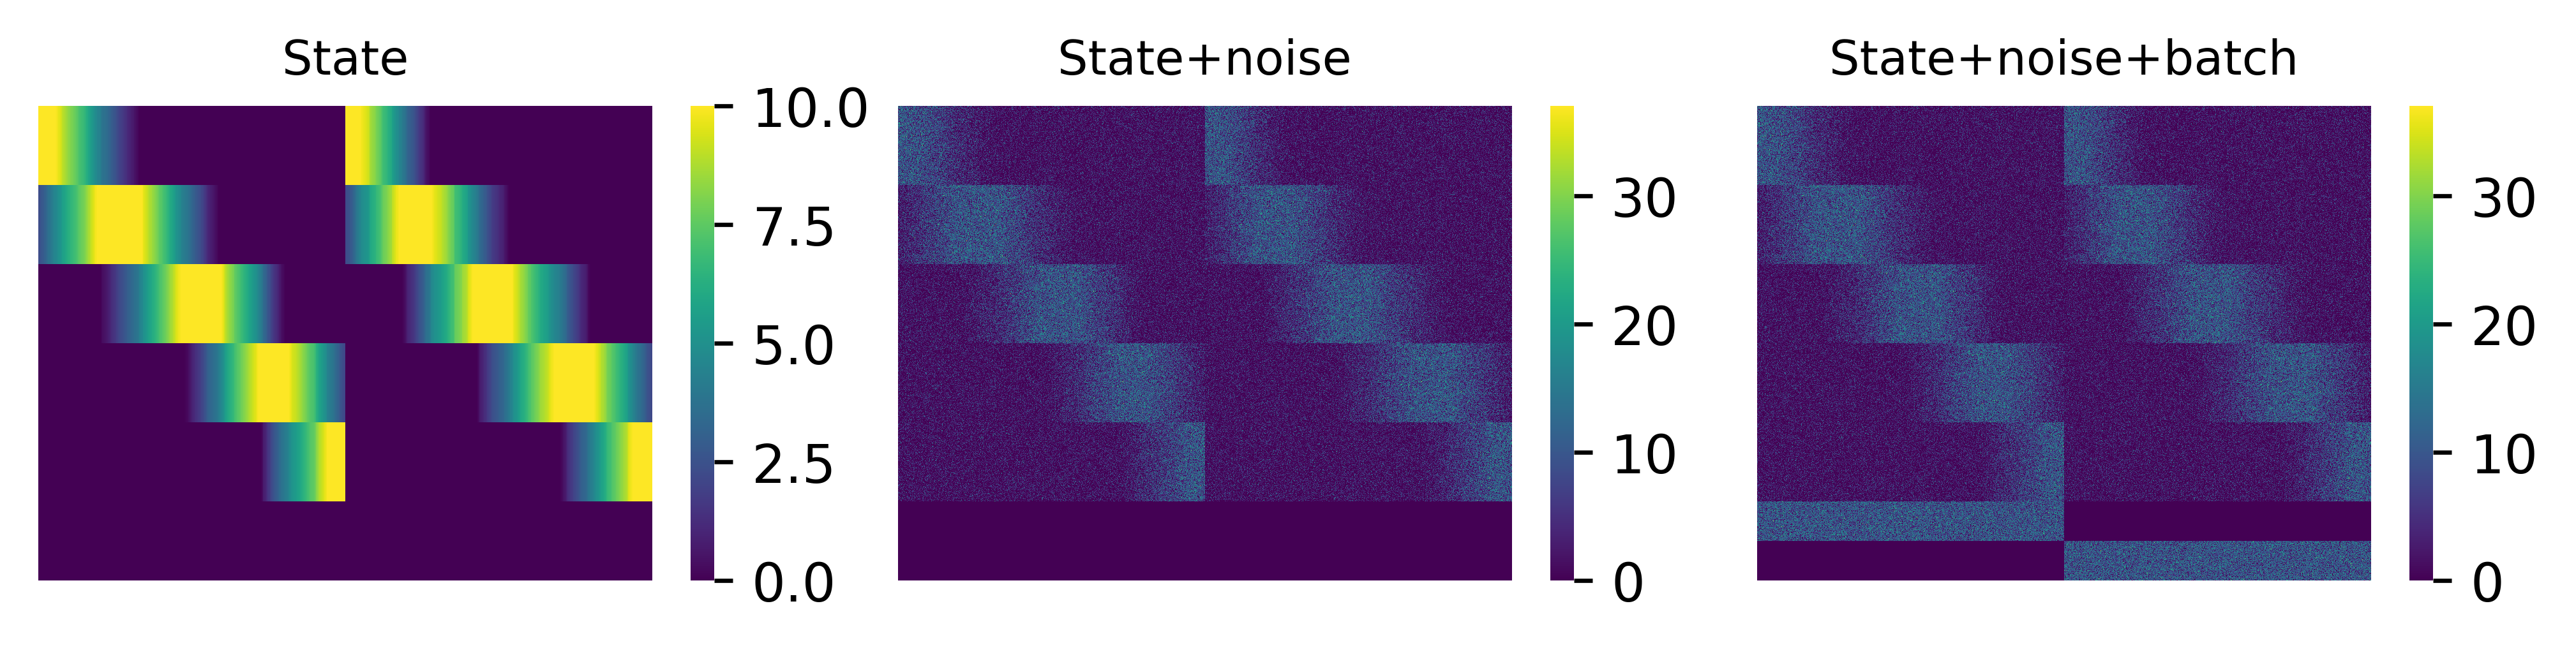

In [17]:
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 3
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"data_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

## Integration pipeline

In [9]:
run_methods = concord_methods + ['contrastive']
latent_dim = 30


In [10]:
# Add ground truth
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='no_noise_PCA', n_pc=latent_dim, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='wt_noise_PCA', n_pc=latent_dim, random_state=seed)
# Put the PCA result in the adata object, so only one object is needed
adata.obsm['no_noise'] = adata.obsm['no_noise_PCA'] = adata_state.obsm['no_noise_PCA']
adata.obsm['wt_noise'] = adata.obsm['wt_noise_PCA'] = adata_state.obsm['wt_noise_PCA']
ccd.ul.run_umap(adata, source_key='no_noise', result_key='no_noise_UMAP', n_components=2, random_state=seed)
ccd.ul.run_umap(adata, source_key='wt_noise', result_key='wt_noise_UMAP', n_components=2, random_state=seed)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
concord_kwargs = {
    'batch_size': 32,
    'n_epochs': 20,
    'encoder_dims': [128, 64, 32],
    'preload_dense': True,
    'verbose': False,
}
profile_logs = ccd.bm.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=run_methods,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=latent_dim,                        # Latent dimensionality for PCA and embeddings
    device="cpu",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,                   # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=42,                              # Random seed for reproducibility
    compute_umap=False,                        # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    verbose=True,                        # Print progress messages
    concord_kwargs=concord_kwargs,          # Additional kwargs for CONCORD
)


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
concord - WARNING - FAISS not found. Using sklearn for k-NN computation.
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_knn: 3.24s | 6.28 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_hcl: 1.77s | 1.31 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skippin

contrastive: 1.70s | 1.92 MB RAM | 0.00 MB VRAM
✅ All selected methods completed.


In [12]:
for basis in run_methods:
    if 'PCA' not in basis:
        n_pc = min(adata.obsm[basis].shape[1], adata.shape[0]) - 1
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)
    print("Running UMAP for", basis)
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

Running UMAP for concord_hcl
Running UMAP for concord_knn
Running UMAP for contrastive


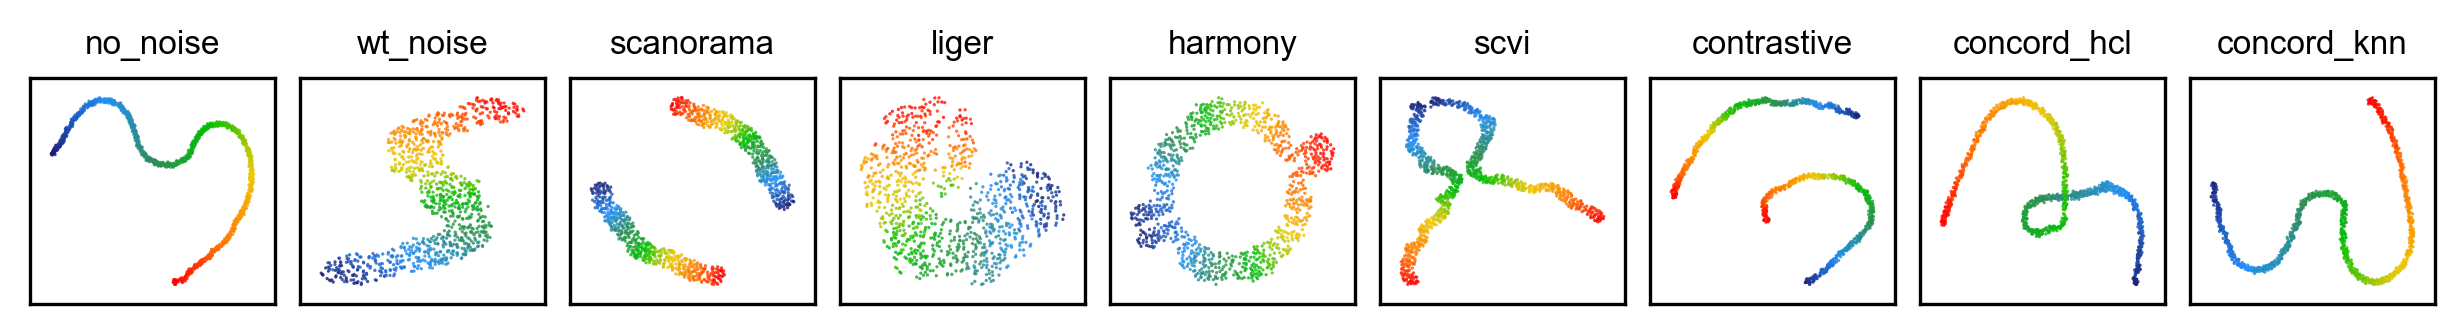

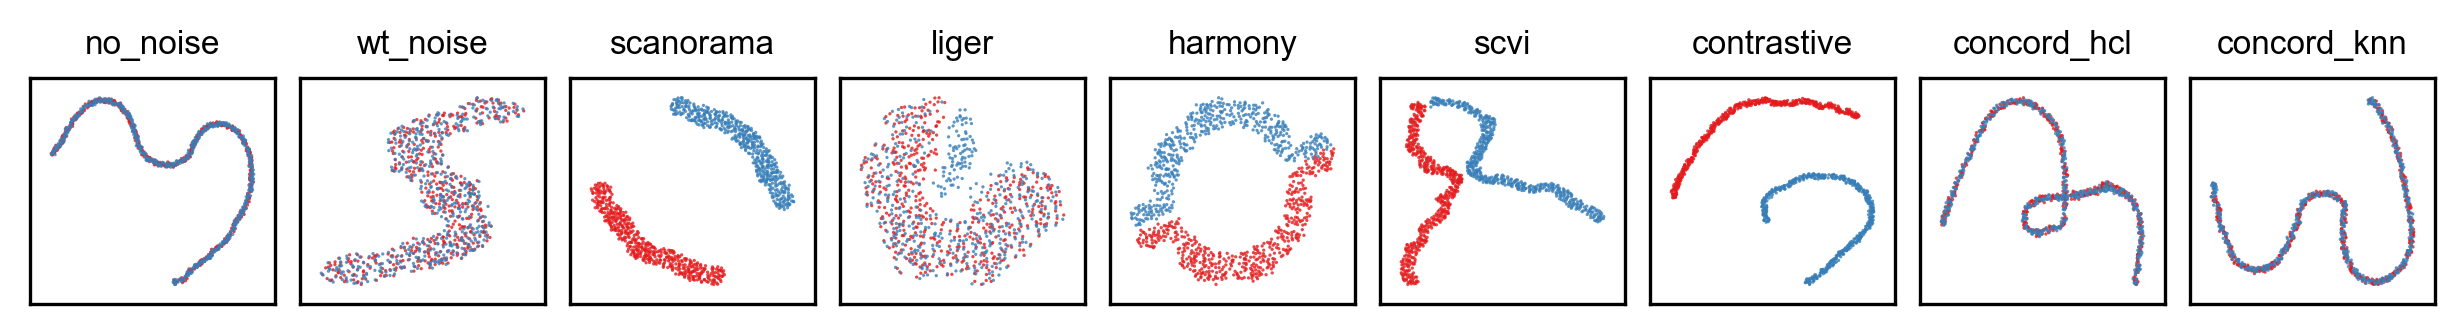

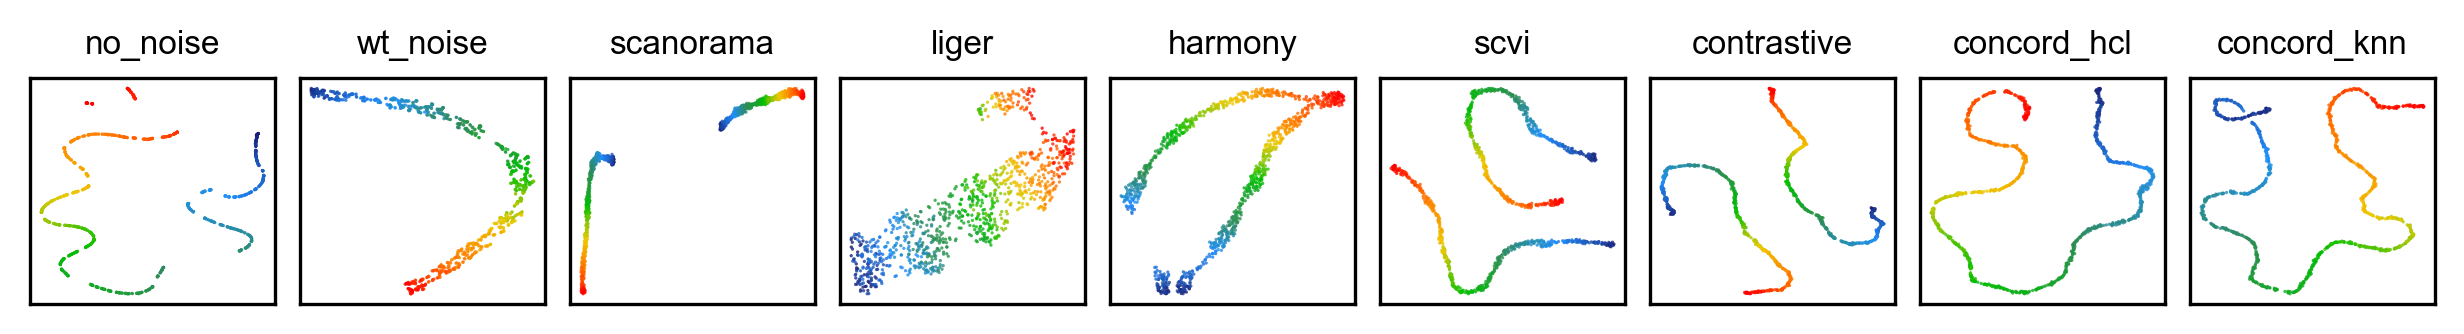

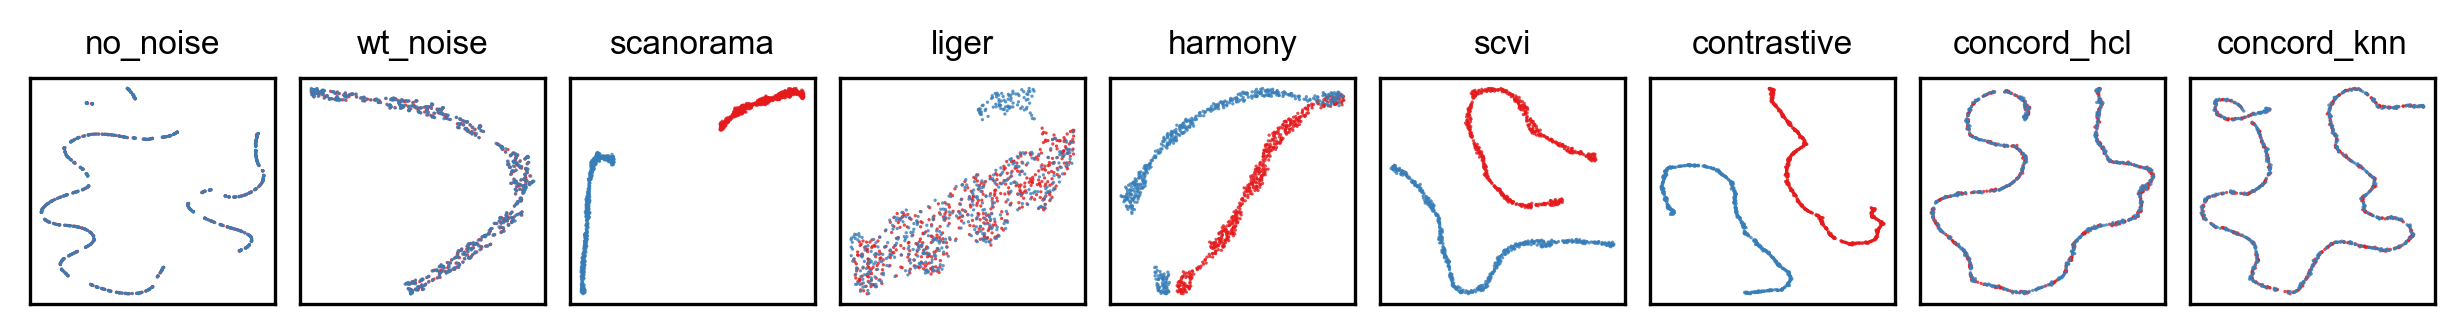

In [15]:
# plot everything
import matplotlib.pyplot as plt

show_keys = [key for key in combined_keys if key != 'unintegrated']

# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch']
basis_types = ['KNN', 'UMAP']
#basis_types = ['PCA']

font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'BlueGreenRed', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed+1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [ ]:
# Find the indices of common genes between `adata` and `adata_state`
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_knn', path=batch_indices, sigma=2)
adata.obsm['concord_knn_sorted'] = adata.obsm['concord_knn'][:, feature_order]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_hcl', path=batch_indices, sigma=2)
adata.obsm['concord_hcl_sorted'] = adata.obsm['concord_hcl'][:, feature_order]


In [13]:
adata.shape

(1000, 1200)

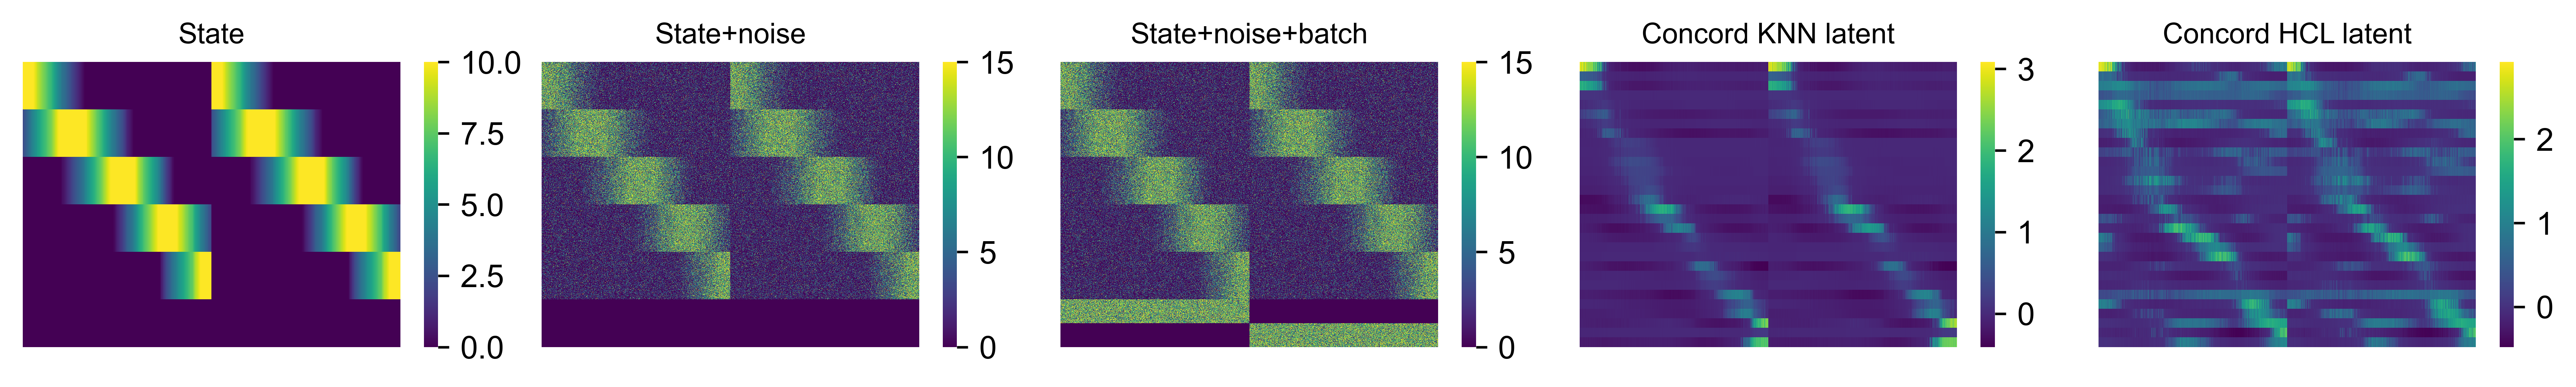

In [30]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
_, _, state_pal = ccd.pl.get_color_mapping(adata, state_key, pal='Paired', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata, batch_key, pal='Set1', seed=seed)
pal = {state_key: state_pal, batch_key: batch_pal}
dpi = 600
with plt.rc_context(rc=custom_rc):
    fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
    ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='wt_noise', vmax=15, obs_keys=[state_key], ax = axes[1], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='X', vmax=15, obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_knn_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord KNN latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_hcl_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord HCL latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    plt.tight_layout(w_pad=0.0, h_pad=0.1)
    plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [31]:
# Save result
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")
print(f"Saved adata_state to {data_dir / f'adata_state_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_trajectory/adata_Aug11-1607.h5ad
Saved adata_state to ../data/simulation_trajectory/adata_state_Aug11-1607.h5ad
